In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from scipy.io import arff
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer



pd.set_option('display.max_columns', None)


In [30]:
path = r'D:\Studies\Fourth Semester\Autonomous Systems A\Truck-Platooning-Simulation-CARLA\Machine Learning\Mohamed Amer - Random Forest Classifier\NSL-KDD new dataset\KDDTrain+.arff'
data, meta = arff.loadarff(path)

# Convert to DataFrame
df = pd.DataFrame(data)

# Decode byte strings
for col in df.select_dtypes([object]):
    df[col] = df[col].str.decode('utf-8')

# Show first few rows
print(df.describe(include='all'))


            duration protocol_type service    flag     src_bytes  \
count   125973.00000        125973  125973  125973  1.259730e+05   
unique           NaN             3      70      11           NaN   
top              NaN           tcp    http      SF           NaN   
freq             NaN        102689   40338   74945           NaN   
mean       287.14465           NaN     NaN     NaN  4.556674e+04   
std       2604.51531           NaN     NaN     NaN  5.870331e+06   
min          0.00000           NaN     NaN     NaN  0.000000e+00   
25%          0.00000           NaN     NaN     NaN  0.000000e+00   
50%          0.00000           NaN     NaN     NaN  4.400000e+01   
75%          0.00000           NaN     NaN     NaN  2.760000e+02   
max      42908.00000           NaN     NaN     NaN  1.379964e+09   

           dst_bytes    land  wrong_fragment         urgent            hot  \
count   1.259730e+05  125973   125973.000000  125973.000000  125973.000000   
unique           NaN       

In [31]:
# Check for missing values
print(df.isnull().sum())
#Drop always Zero columns
df = df.drop(['num_outbound_cmds', 'is_host_login', 'is_guest_login'], axis=1)


duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [32]:
#encoding the class column
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])
y=df['class']


In [33]:
# Separate features (X) and target (y)
X = df.drop('class', axis=1)


In [34]:
# Identify categorical and numerical columns for the pipeline
categorical_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in']
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()


In [35]:
# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore') 

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' 
)


In [36]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  
    ('pca', PCA(n_components=0.95)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
         min_samples_split=5,
         min_samples_leaf=7,
        max_depth=10,
        n_jobs=-1,  
        max_features='sqrt',
        random_state=42,
        class_weight='balanced',
        bootstrap=True,
        oob_score=True
    ))
])

In [37]:
# Fit the pipeline on the training data
pipeline.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'num_root',
                                                   'num_file_creations',
                                                   'num_shells',
                                                   'num_access_files', 'count',
                                                   'srv_count', 'serror_rate',
                       

In [38]:
test_path = r'D:\Studies\Fourth Semester\Autonomous Systems A\Truck-Platooning-Simulation-CARLA\Machine Learning\Mohamed Amer - Random Forest Classifier\NSL-KDD new dataset\KDDTest+.arff'
data_test, meta_test = arff.loadarff(test_path)
df_test = pd.DataFrame(data_test)
for col in df_test.select_dtypes([object]):
    df_test[col] = df_test[col].str.decode('utf-8')


In [39]:
# Preprocess test data - same as train data
df_test = df_test.drop(['num_outbound_cmds', 'is_host_login', 'is_guest_login'], axis=1)
y_test = df_test['class']
y_test_encoded = le.transform(y_test)
X_test = df_test.drop('class', axis=1)


In [40]:
# Predict using the fitted pipeline
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print(classification_report(y_test_encoded, y_pred))


Accuracy: 0.7971965933286018
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     12833
           1       0.69      0.97      0.80      9711

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.80     22544



In [41]:
# Calculate train and test accuracy using the pipeline
train_acc = pipeline.score(X, y)
test_acc = pipeline.score(X_test, y_test_encoded)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)


Train accuracy: 0.9967850253625777
Test accuracy: 0.7971965933286018


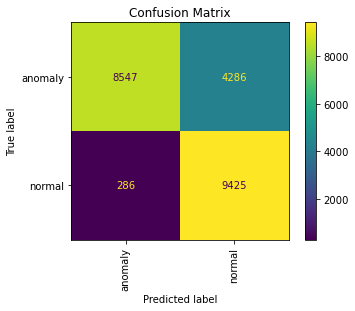

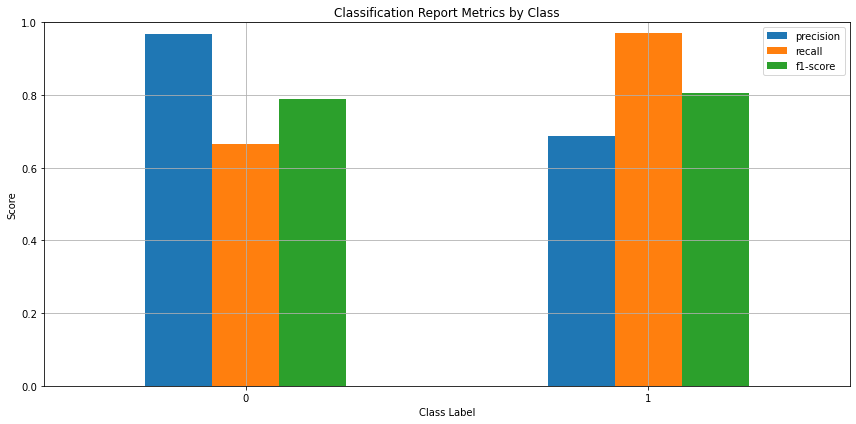

In [49]:
# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

# Get classification report as dictionary
report_dict = classification_report(y_test_encoded, y_pred, output_dict=True)

# Convert to DataFrame for visualization
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])

# Plot precision, recall, f1-score for each class
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title("Classification Report Metrics by Class")
plt.ylabel("Score")
plt.xlabel("Class Label")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()
